In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import cv2

### 1. Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую)

Original image dimensions: (150, 200, 3)


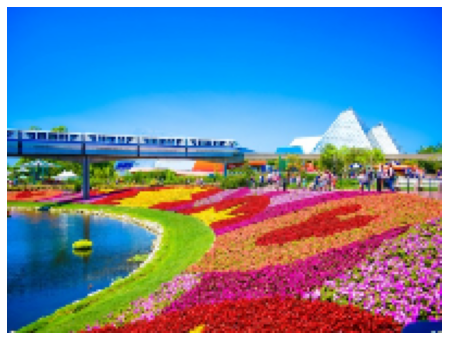

In [2]:
image = cv2.imread('YArkaya-klumba-Bright-flower-bed-6000x4000-700x466.jpg')
image = cv2.resize(image, (200, 150))

b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
rgb_image = cv2.merge([r, g, b])

dimensions = rgb_image.shape
print('Original image dimensions:', dimensions)

plt.figure(figsize=(10,6))
plt.axis('off')
plt.imshow(rgb_image)
plt.show()

**Необходимо создать матрицу, в которой каждый пиксель будет представлен тремя значениями интесивности цветов: `[R, G, B]`**

In [3]:
rgb_matrix = rgb_image.reshape(dimensions[0] * dimensions[1], dimensions[2])

print('Reshaped dimensions:', rgb_matrix.shape)
rgb_matrix

Reshaped dimensions: (30000, 3)


array([[  0,  92, 254],
       [  0,  93, 253],
       [  0,  96, 255],
       ...,
       [  0,  28, 115],
       [131, 141, 139],
       [144, 155, 147]], dtype=uint8)

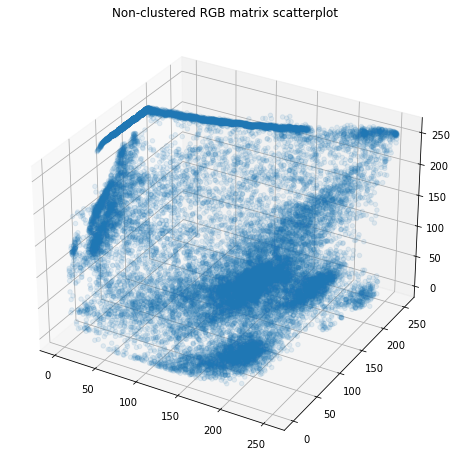

In [4]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter(rgb_matrix[:,0], rgb_matrix[:,1], rgb_matrix[:,2], alpha=0.1)
plt.title('Non-clustered RGB matrix scatterplot')
plt.show()

### 2. Реализуйте три модели кластеризации:
- a) KMeans. Рассмотрите число кластеров K = 2, 5, 10, 20
- b) DBSCAN
- c) AgglomerativeClustering. Рассмотрите число кластеров K = 2, 5, 10, 20

**Для работы кластеризаторов я отшкалирую данные**

In [5]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import time

rgb_matrix_scaled = StandardScaler().fit_transform(rgb_matrix)

**Результаты работы каждого из кластеризаторов я буду добавлять в словарь. В итоге у меня получится три словаря, по одному для каждой из моделей кластеризации. Также для большей наглядности я буду отрисовывать трехмерные графики разделения пикселей на кластеры, чтобы для каждой из моделей можно было оценить влияние различных значений гиперпараметров на разбиение. Дополнительно буду измерять время работы для каждой группы кластеризаторов одного типа.**

CPU times: total: 5 s
Wall time: 1.67 s


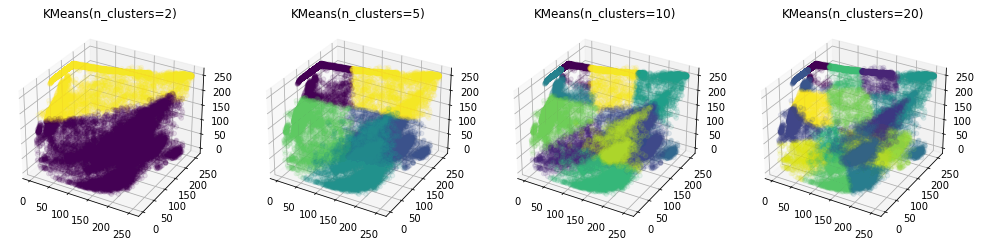

In [6]:
%%time
fig = plt.figure(figsize=(17, 6))

ks = [2, 5, 10, 20]
kmeans_labels = {}

for i, k in enumerate(ks):
    clf = KMeans(n_clusters=k)
    labels = clf.fit_predict(rgb_matrix_scaled)
    kmeans_labels[clf] = labels
    
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    ax.scatter(rgb_matrix[:,0], rgb_matrix[:,1], rgb_matrix[:,2], alpha=0.1, c=labels)
    ax.set_title(clf)

CPU times: total: 1min 15s
Wall time: 1min 16s


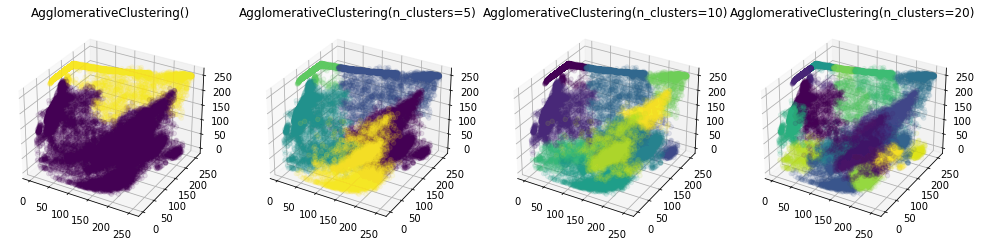

In [7]:
%%time
fig = plt.figure(figsize=(17, 6))

ks = [2, 5, 10, 20]
aggloclust_labels = {}

for i, k in enumerate(ks):
    clf = AgglomerativeClustering(n_clusters=k)
    labels = clf.fit_predict(rgb_matrix_scaled)
    aggloclust_labels[clf] = labels
    
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    ax.scatter(rgb_matrix[:,0], rgb_matrix[:,1], rgb_matrix[:,2], alpha=0.1, c=labels)
    ax.set_title(clf)

CPU times: total: 1.45 s
Wall time: 1.49 s


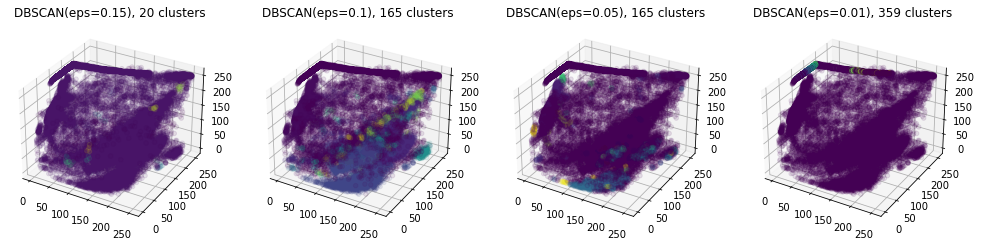

In [8]:
%%time
fig = plt.figure(figsize=(17, 6))

eps = [0.15, 0.1, 0.05, 0.01]
dbscan_labels = {}

for i, e in enumerate(eps):
    clf = DBSCAN(eps=e, min_samples=5)
    labels = clf.fit_predict(rgb_matrix_scaled)
    dbscan_labels[clf] = labels
    
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    ax.scatter(rgb_matrix[:,0], rgb_matrix[:,1], rgb_matrix[:,2], alpha=0.1, c=labels)
    ax.set_title(f'{clf}, {len(np.unique(labels))} clusters')

### 3. Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM

**Я напишу функцию для подсчета метрики SSIM и отрисовки изображений, полученных с помощью скластеризованных RGB-матриц. Так для каждого типа модели кластеризации можно будет наглядно оценить качество ее работы в связке с количеством кластеров, и сравнить визуальное качество со значением метрики SSIM.**

In [9]:
from skimage.metrics import structural_similarity as ssim

def ssim_and_show(labels_dict):
    fig = plt.figure(figsize=(17, 10))

    for i, (alg, labels) in enumerate(labels_dict.items()):
        new_rgb_matrix = rgb_matrix.copy()
        
        for l in np.unique(labels):
            new_rgb_matrix[labels == l] = np.mean(rgb_matrix[labels == l], axis=0)
        
        new_rgb_image = new_rgb_matrix.reshape(dimensions[0], dimensions[1], dimensions[2])
        ssim_score = round(ssim(rgb_image, new_rgb_image, channel_axis=2), 2)

        ax = fig.add_subplot(2, 2, i+1)
        ax.axis('off')
        ax.imshow(new_rgb_image)
        ax.set_title(f'{alg}\n{len(np.unique(labels))} clusters, SSIM = {ssim_score}')

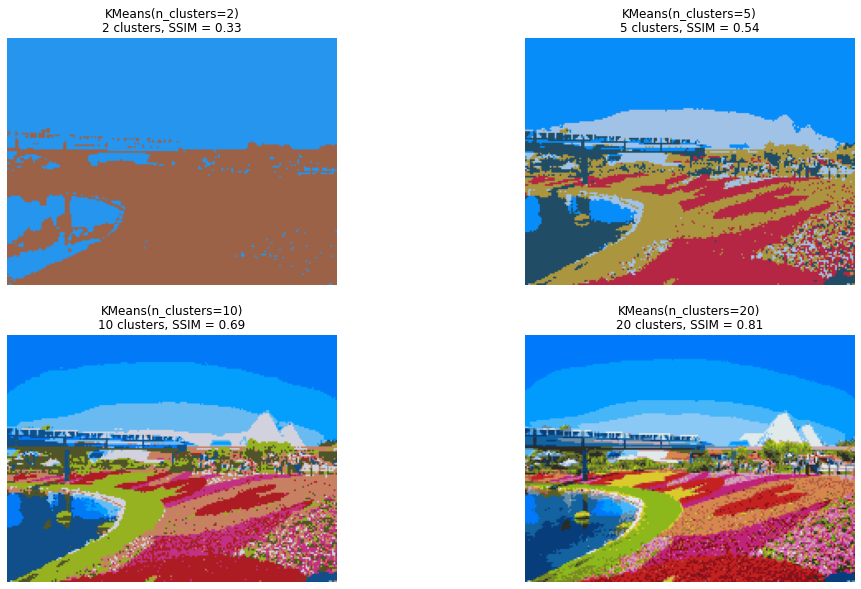

In [10]:
ssim_and_show(kmeans_labels)

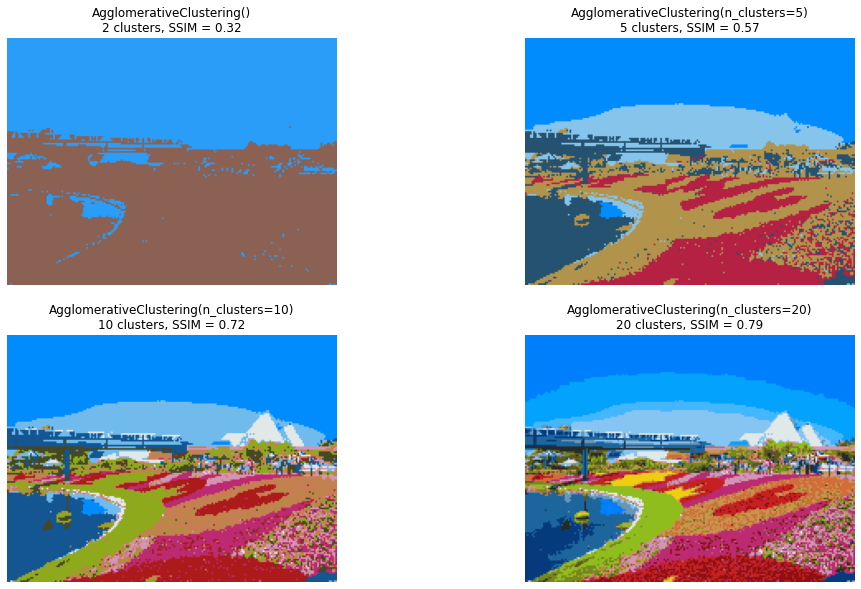

In [11]:
ssim_and_show(aggloclust_labels)

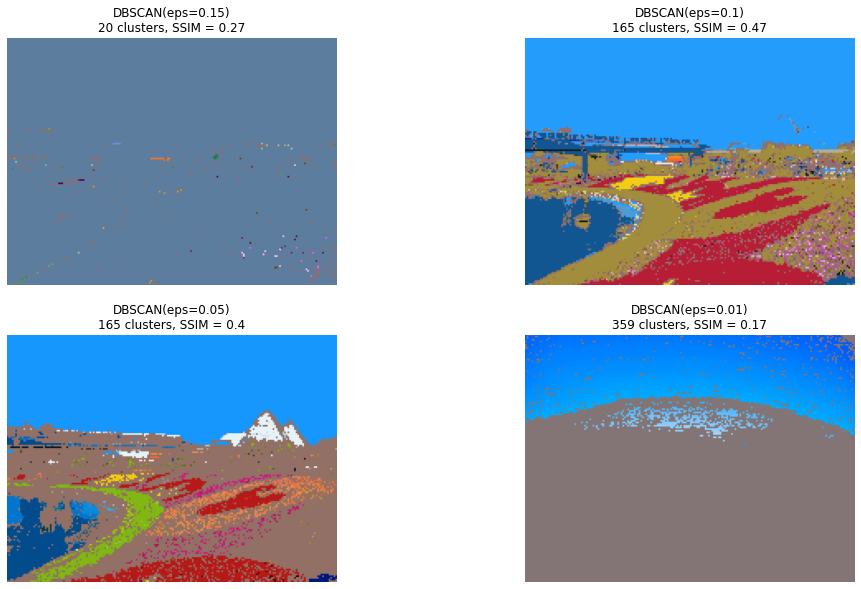

In [12]:
ssim_and_show(dbscan_labels)

### 4. Сформулируйте выводы по проделанной работе
- `KMeans` отработала гораздо лучше остальных моделей. Значение метрики SSIM уже на 5 кластерах было `0.54`, и получившееся изображение уже напоминало исходную картинку. С ростом количества кластеров изображение становилось всё ближе к оригиналу, и на 20 кластерах SSIM уже было `0.81` - весьма неплохой показатель с учетом сокращения количества цветов всего до 20. Кроме того модель отрабатывала очень быстро и завершила свои 4 подхода кластеризации всего за `1.67 секунд`.


- `AgglomerativeClustering` показала схожий результат в плане визуального качества изображения и значений метрики SSIM. Но на 20 кластерах эта модель все-таки уступила `KMeans`, выдав SSIM на уровне `0.79`. Это ненамного меньше, но здесь важнее сравнить скорость работы двух алгоритмов и их ресурсоёмкость. `AgglomerativeClustering` потребовалось `76 секунд` на 4 подхода кластеризации. Но еще важнее, что именно для этой модели мне потребовалось снизить разрешение изображения с `700x466` до `200x150` пикселей, фактически уменьшив их количество более чем в 10 раз. Иначе памяти компьютера не хватало на реализацию алгоритма.


- `DBSCAN` справилась хуже всех остальных моделей. Очертания исходной картинки появились лишь на 165 кластерах, но метрика SSIM при этом едва достигла значения `0,47`. Похоже, что дальше с уменьшением параметра `eps`, и, соответственно, с ростом количества кластеров качество изображения только продолжает снижаться. На 359 кластерах изображение выглядит хуже, чем на 2 кластерах у других моделей. Также настройка параметра `eps` гораздо сложнее и отрабатывает не так интуитивно, как параметр `n-clusters` в других моделях. В целом, `DBSCAN` выглядит не очень подходящим кандидатом для данной задачи. При этом модель отработала за минимальное время `1.49 секунд`.